In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


#  Set Keras backend


In [2]:
import os
os.environ["KERAS_BACKEND"] =  "tensorflow" # "torch" #

import keras

print(f"Keras version {keras.__version__}, backend: {keras.backend.backend()}")



Keras version 3.8.0, backend: tensorflow



## List version of backend


In [3]:
if keras.backend.backend() ==  "tensorflow":
  import tensorflow as tf
  print(f"TensorFlow version {tf.__version__}")
elif keras.backend.backend() ==  "torch":
  import torch
  print(f"PyTorch version {torch.__version__}")


TensorFlow version 2.18.0


# List GPU's available


In [4]:
# prompt: depending on backend, list gpu devices available

if keras.backend.backend() == "tensorflow":
  gpu_available = tf.config.list_physical_devices('GPU')
  if gpu_available:
    print("GPU available with TensorFlow:")
    for gpu in gpu_available:
      print(f"  {gpu}")
  else:
    print("No GPU available with TensorFlow.")
elif keras.backend.backend() == "torch":
  if torch.cuda.is_available():
    print("GPU available with PyTorch:")
    device_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
    print(f"GPUs: {', '.join(device_names)}")
  else:
    print("No GPU available with PyTorch.")
else:
    print("Unknown Keras backend.")

No GPU available with TensorFlow.


# Standard imports

In [54]:
import keras

import numpy as np
import os

import matplotlib.pyplot as plt
import IPython

import pdb

from pprint import pprint


# Keras imports

In [55]:
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import plot_model

# Utility routines

In [56]:
batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

def prepareData(X_train, y_train, X_test, y_test, flatten=True):
  if keras.backend.image_data_format() == 'channels_first':
      X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
      X_test  = X_test.reshape( X_test.shape[0], 1, img_rows, img_cols)
      input_shape = (1, img_rows, img_cols)
  else:
      X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
      X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
      input_shape = (img_rows, img_cols, 1)

  return input_shape, X_train, y_train, X_test, y_test


In [57]:
def showImage(img, ax=plt, title=None, cmap=None):
  # Some datasets (e.g., MNIST) have only 1 channel instead of 3
  if img.shape[-1] == 1:
    img = img[:,:, 0]
    cmap = "gray"


  if cmap is None:
    _= ax.imshow(img)
  else:
    _= ax.imshow(img, cmap=cmap)

  if title is not None:
    ax.set_title(title)


def showTrain(Xtrain, ytrain, num=5):
  #  ytrain is OHE
  num_classes = ytrain.shape[-1]

  fig = plt.figure(figsize=(12,12))
  for thisClass in range(0, num_classes):
    Xtrain_thisClass = Xtrain[ ytrain[:,thisClass] == 1]

    for i in range(0,num):
      ax = fig.add_subplot(num_classes, num, thisClass * num + i +1)
      showImage(Xtrain_thisClass[i], ax)

      # ax.set_title(y[i])
      # ax.set_xlabel( idxs[i] )
      ax.set_xticks([])
      ax.set_yticks([])


def trainModel(model, modelName, X_train, y_train, X_test, y_test,
               batch_size = 128, epochs=20, num_classes=10):
  es_callback = EarlyStopping(monitor='val_loss', min_delta=.005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

  callbacks = [ es_callback,
                ModelCheckpoint(filepath=modelName + ".keras", monitor='acc', save_best_only=True)
              ]

  model.compile(loss=keras.losses.categorical_crossentropy,
                metrics=['acc']
                )

  # If there is no explicit `Input` layer, we can't plot the model until either
  # - it is called with an example for the first time
  # - OR is built via `build`
  # Both of these inform the model of the shape of its input
  # NOTE: build takes an argument with a batch dimension of None
  #       in contrast to the input_shape argument of a layer which DOES NOT take a batch dimension
  if not model.built:
    model.build(input_shape=(None,) + X_train[0].shape)

  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)


  model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            callbacks=callbacks,
            validation_split=0.1
            )

  score = model.evaluate(X_test, y_test, verbose=0)
  print(f"Test loss {score[0]:.2f}")
  print(f"Test accuracy: {score[1]:.2f}")

  return score[1], plotFile

# Sets all random seeds (Python, NumPy, and backend framework, e.g. TF).

We are doing this so that the execution is reproducible across runs.

In [58]:
keras.utils.set_random_seed(42)

# Get the data, prepare it

Note
- we are using OHE for the targets
  - so loss is `categorical_crossentropy` (without the `sparse_` prefix)

In [59]:

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) =  fashion_mnist.load_data()

input_shape, X_train, y_train, X_test, y_test = prepareData(X_train, y_train, X_test, y_test)


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

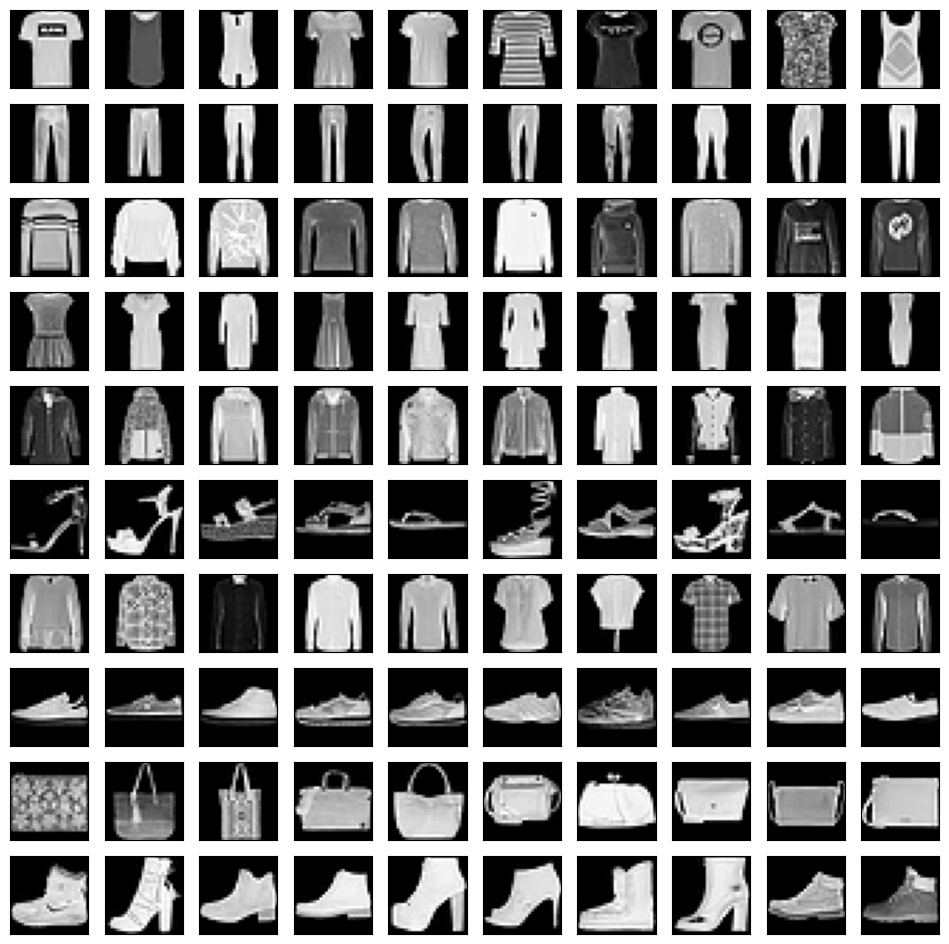

In [60]:
showTrain(X_train, y_train, num=10)

# Routines to create models

In [61]:

def createModelClassifier(input_shape, num_classes):
  model = Sequential( [
                        # Input(shape=input_shape), # Explicit Input layer
                        Flatten(),
                        Dense(num_classes, activation='softmax')
                        ]
                     )

  return model


In [62]:
def createModel(input_shape, num_classes,
                num_filters=[32], pool=[], extraDense=False):
  # Create first layer: needs input_spec
  model = Sequential( [
                       Conv2D(num_filters[0], kernel_size=(3, 3),
                                activation='relu',
                                padding="same")
                        ]
                    )

  # Add more Conv/Pooling layers
  for i in range(1, len(num_filters)):
    if  (len(pool) > i) and pool[i]:
      print("Adding Pool + Conv block with {n:d} filters".format(n=num_filters[i]))
      model.add( MaxPooling2D(pool_size=(2, 2)) )
    else:
      print("Adding Conv block with {n:d} filters".format(n=num_filters[i]))

    model.add( Conv2D(num_filters[i], (3, 3), activation='relu', padding="same"))
    model.add( Dropout(0.25))

  # Add tail
  model.add( Flatten() )

  if extraDense:
    model.add( Dense(128, activation='relu') )
    model.add( Dropout(0.5) )

  model.add( Dense(num_classes, activation='softmax') )

  return model


# Model: simple classifier (no convolution)

In [63]:
mnist_classifier_model = createModelClassifier(input_shape, num_classes)
mnist_classifier_model.build( (None,) + X_train[0].shape)


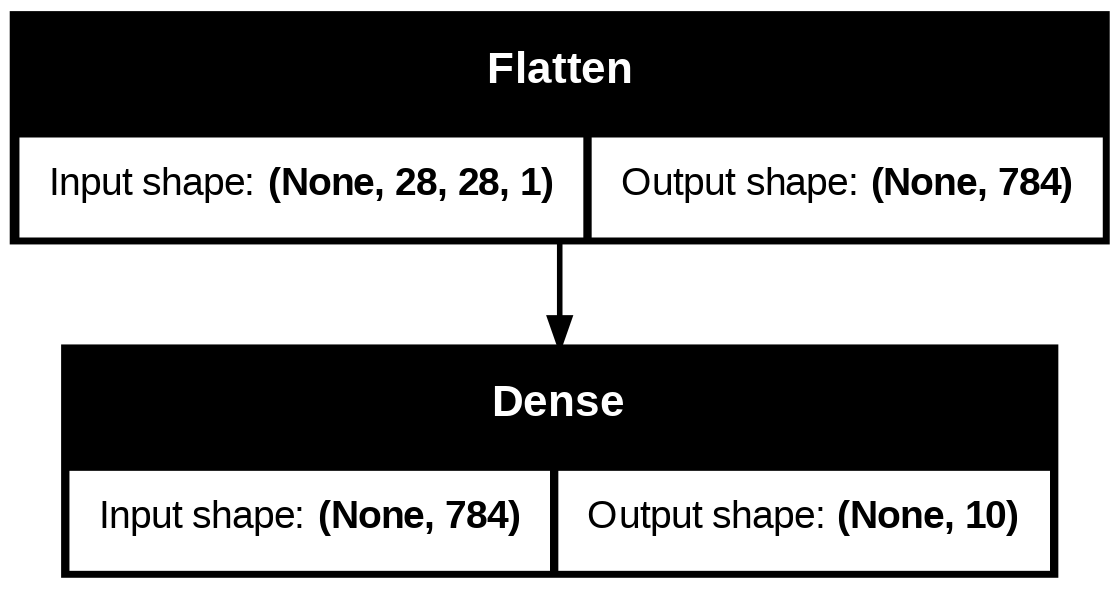

In [64]:
plot_model(mnist_classifier_model, "mnist_classifier.png", show_shapes=True)

In [65]:
modelName="mnist_classifier"

acc, plotFile = trainModel(mnist_classifier_model, modelName, X_train, y_train, X_test, y_test)



Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.6073 - loss: 35.1862 - val_acc: 0.7958 - val_loss: 12.1501
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.7602 - loss: 16.2348 - val_acc: 0.7873 - val_loss: 12.3758
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7769 - loss: 14.5718 - val_acc: 0.7855 - val_loss: 14.7012
Test loss 13.31
Test accuracy: 0.79


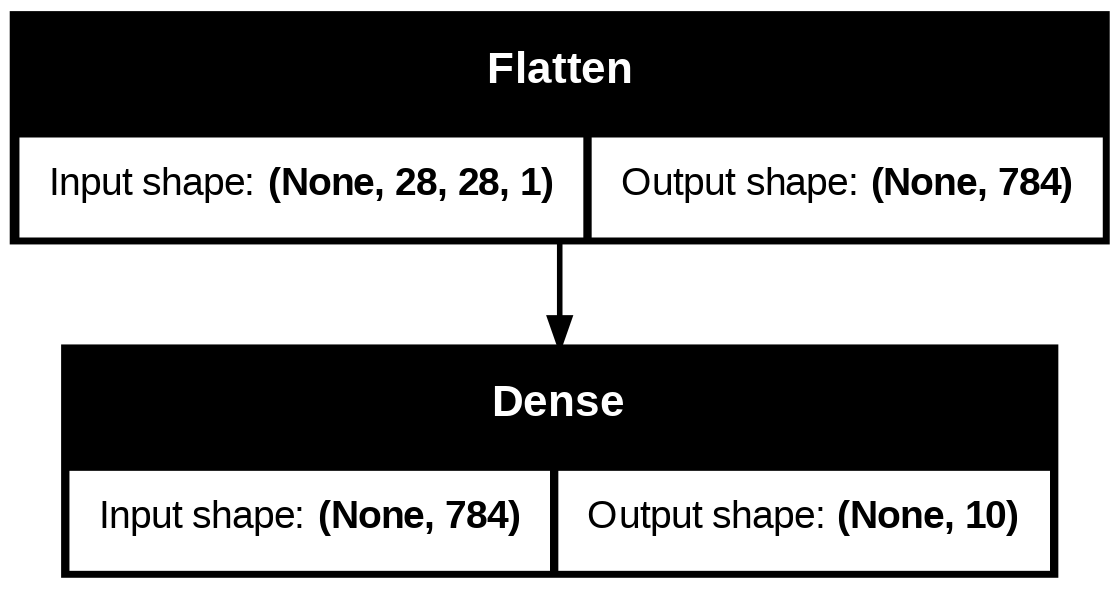

In [66]:
IPython.display.Image( plotFile)

# Model: One Convolutional Layer (32 filters)

In [69]:
mnist_conv1_model = createModel(input_shape, num_classes,
                                num_filters=[32])
modelName="mnist_conv1"



In [70]:
acc, plotFile = trainModel(mnist_conv1_model, modelName, X_train, y_train, X_test, y_test)


Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - acc: 0.7423 - loss: 25.1051 - val_acc: 0.8767 - val_loss: 0.3569
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - acc: 0.8888 - loss: 0.3247 - val_acc: 0.8832 - val_loss: 0.3542
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - acc: 0.9111 - loss: 0.2589 - val_acc: 0.8808 - val_loss: 0.3666
Test loss 0.39
Test accuracy: 0.87


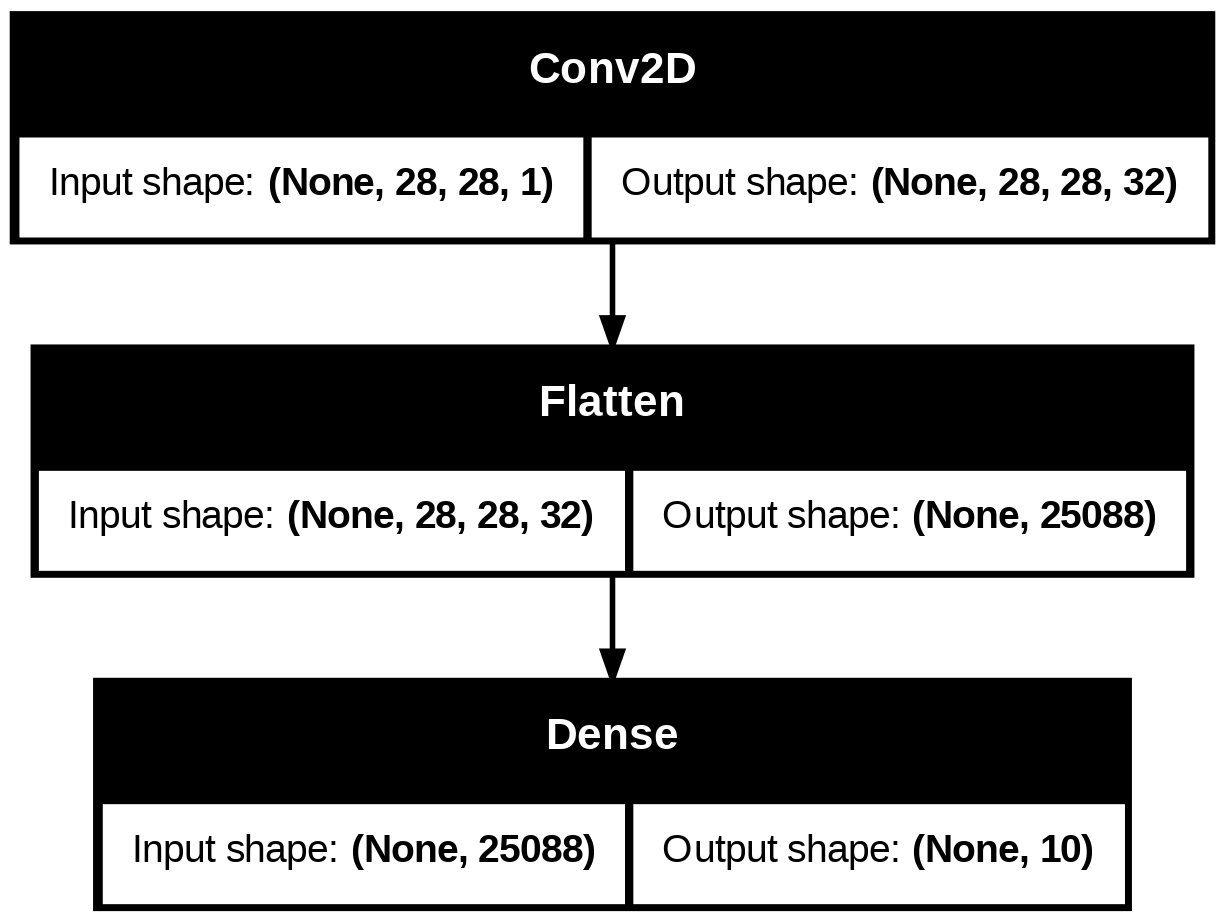

In [71]:
IPython.display.Image( plotFile)

# Model: 2 Convolutional Layers (32, 64 filters)

In [72]:
mnist_conv2_model = createModel(input_shape, num_classes,
                                num_filters=[32, 64])
modelName="mnist_conv2"

acc, plotFile = trainModel(mnist_conv2_model, modelName, X_train, y_train, X_test, y_test)


Adding Conv block with 64 filters
Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 210s 493ms/step - acc: 0.7643 - loss: 14.9221 - val_acc: 0.8802 - val_loss: 0.3409
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 230s 418ms/step - acc: 0.8804 - loss: 0.3512 - val_acc: 0.8807 - val_loss: 0.3412
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 182s 432ms/step - acc: 0.8965 - loss: 0.3027 - val_acc: 0.8875 - val_loss: 0.3271
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 201s 429ms/step - acc: 0.9074 - loss: 0.2716 - val_acc: 0.8887 - val_loss: 0.3253
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 198s 421ms/step - acc: 0.9143 - loss: 0.2498 - val_acc: 0.8862 - val_loss: 0.3818
Test loss 0.37
Test accuracy: 0.88


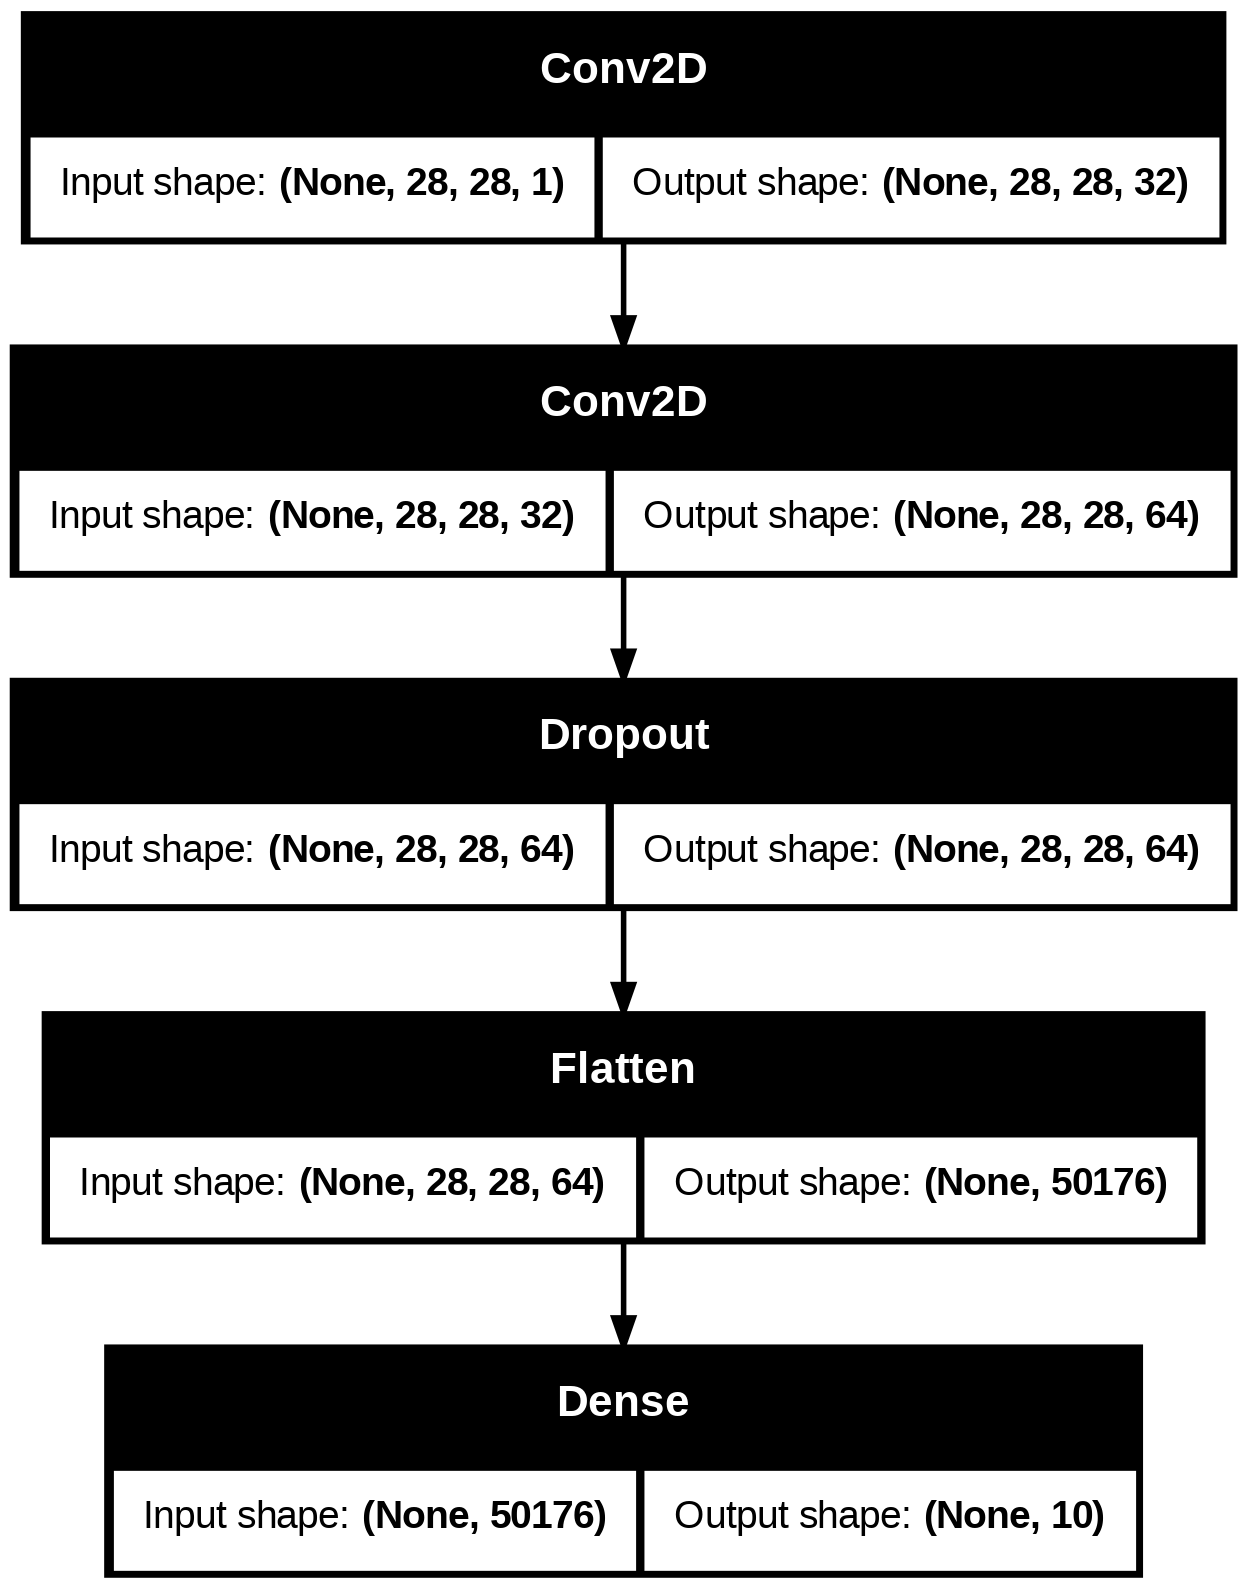

In [73]:
IPython.display.Image( plotFile)

# Model: 2 Convolutional Layers (8, 16 filters, no pooling)

In [74]:
mnist_conv2_8_16_model = createModel(input_shape, num_classes,
                                     num_filters=[8, 16])
modelName="mnist_conv2_8_16"

acc, plotFile = trainModel(mnist_conv2_8_16_model, modelName, X_train, y_train, X_test, y_test)


Adding Conv block with 16 filters
Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - acc: 0.7626 - loss: 3.9567 - val_acc: 0.8808 - val_loss: 0.3471
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - acc: 0.8892 - loss: 0.3219 - val_acc: 0.8932 - val_loss: 0.3238
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - acc: 0.9085 - loss: 0.2662 - val_acc: 0.8912 - val_loss: 0.3327
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - acc: 0.9169 - loss: 0.2373 - val_acc: 0.8898 - val_loss: 0.3408
Test loss 0.35
Test accuracy: 0.88


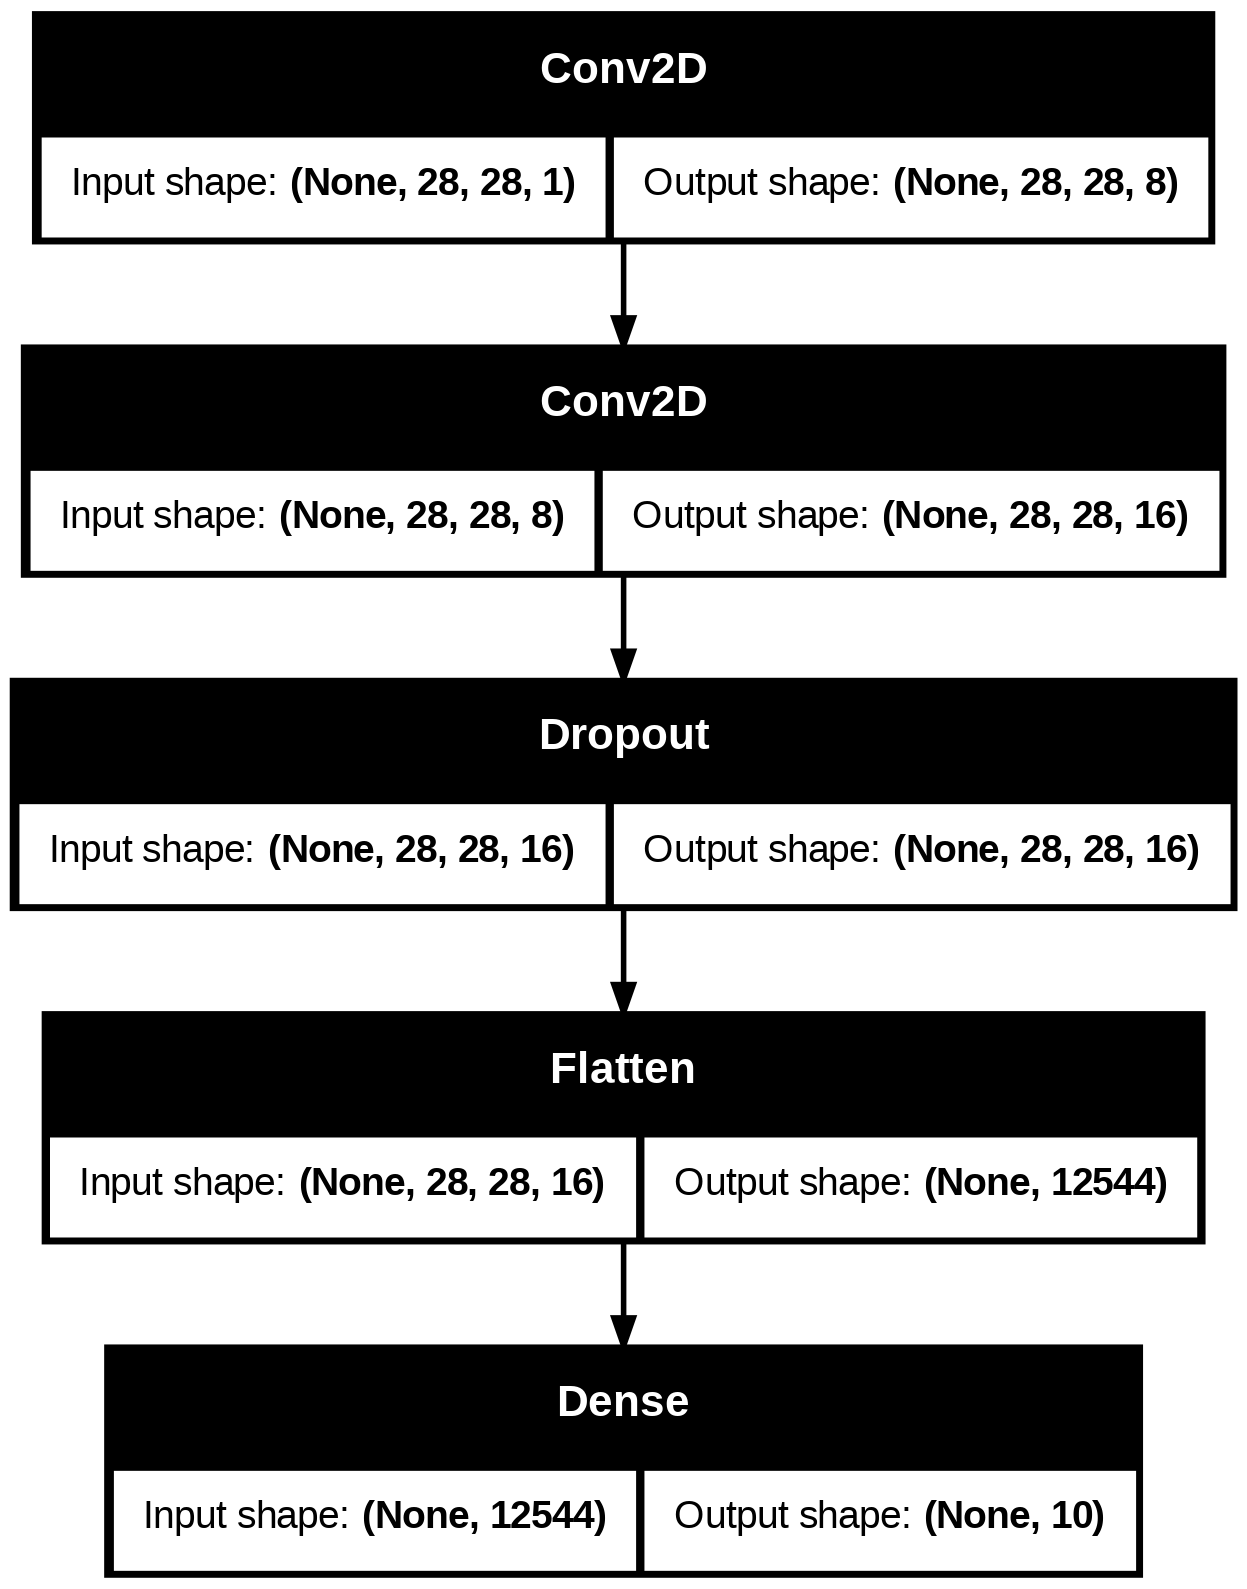

In [75]:
IPython.display.Image( plotFile)


## Count the parameters

In [76]:
mnist_conv2_8_16_model.count_params()

126698

# Model: 2 Convolutional Layers (8, 16 filters, pooling)

In [77]:
mnist_conv2_8_16_pool_model = createModel(input_shape, num_classes,
                                          num_filters=[8, 16], pool=[False, True])
modelName="mnist_conv2_8_16_pool"

acc, plotFile = trainModel(mnist_conv2_8_16_pool_model, modelName, X_train, y_train, X_test, y_test)


Adding Pool + Conv block with 16 filters
Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - acc: 0.6981 - loss: 6.1377 - val_acc: 0.8670 - val_loss: 0.3697
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - acc: 0.8612 - loss: 0.3910 - val_acc: 0.8760 - val_loss: 0.3450
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - acc: 0.8743 - loss: 0.3555 - val_acc: 0.8782 - val_loss: 0.3402
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - acc: 0.8806 - loss: 0.3376 - val_acc: 0.8785 - val_loss: 0.3454
Test loss 0.37
Test accuracy: 0.87


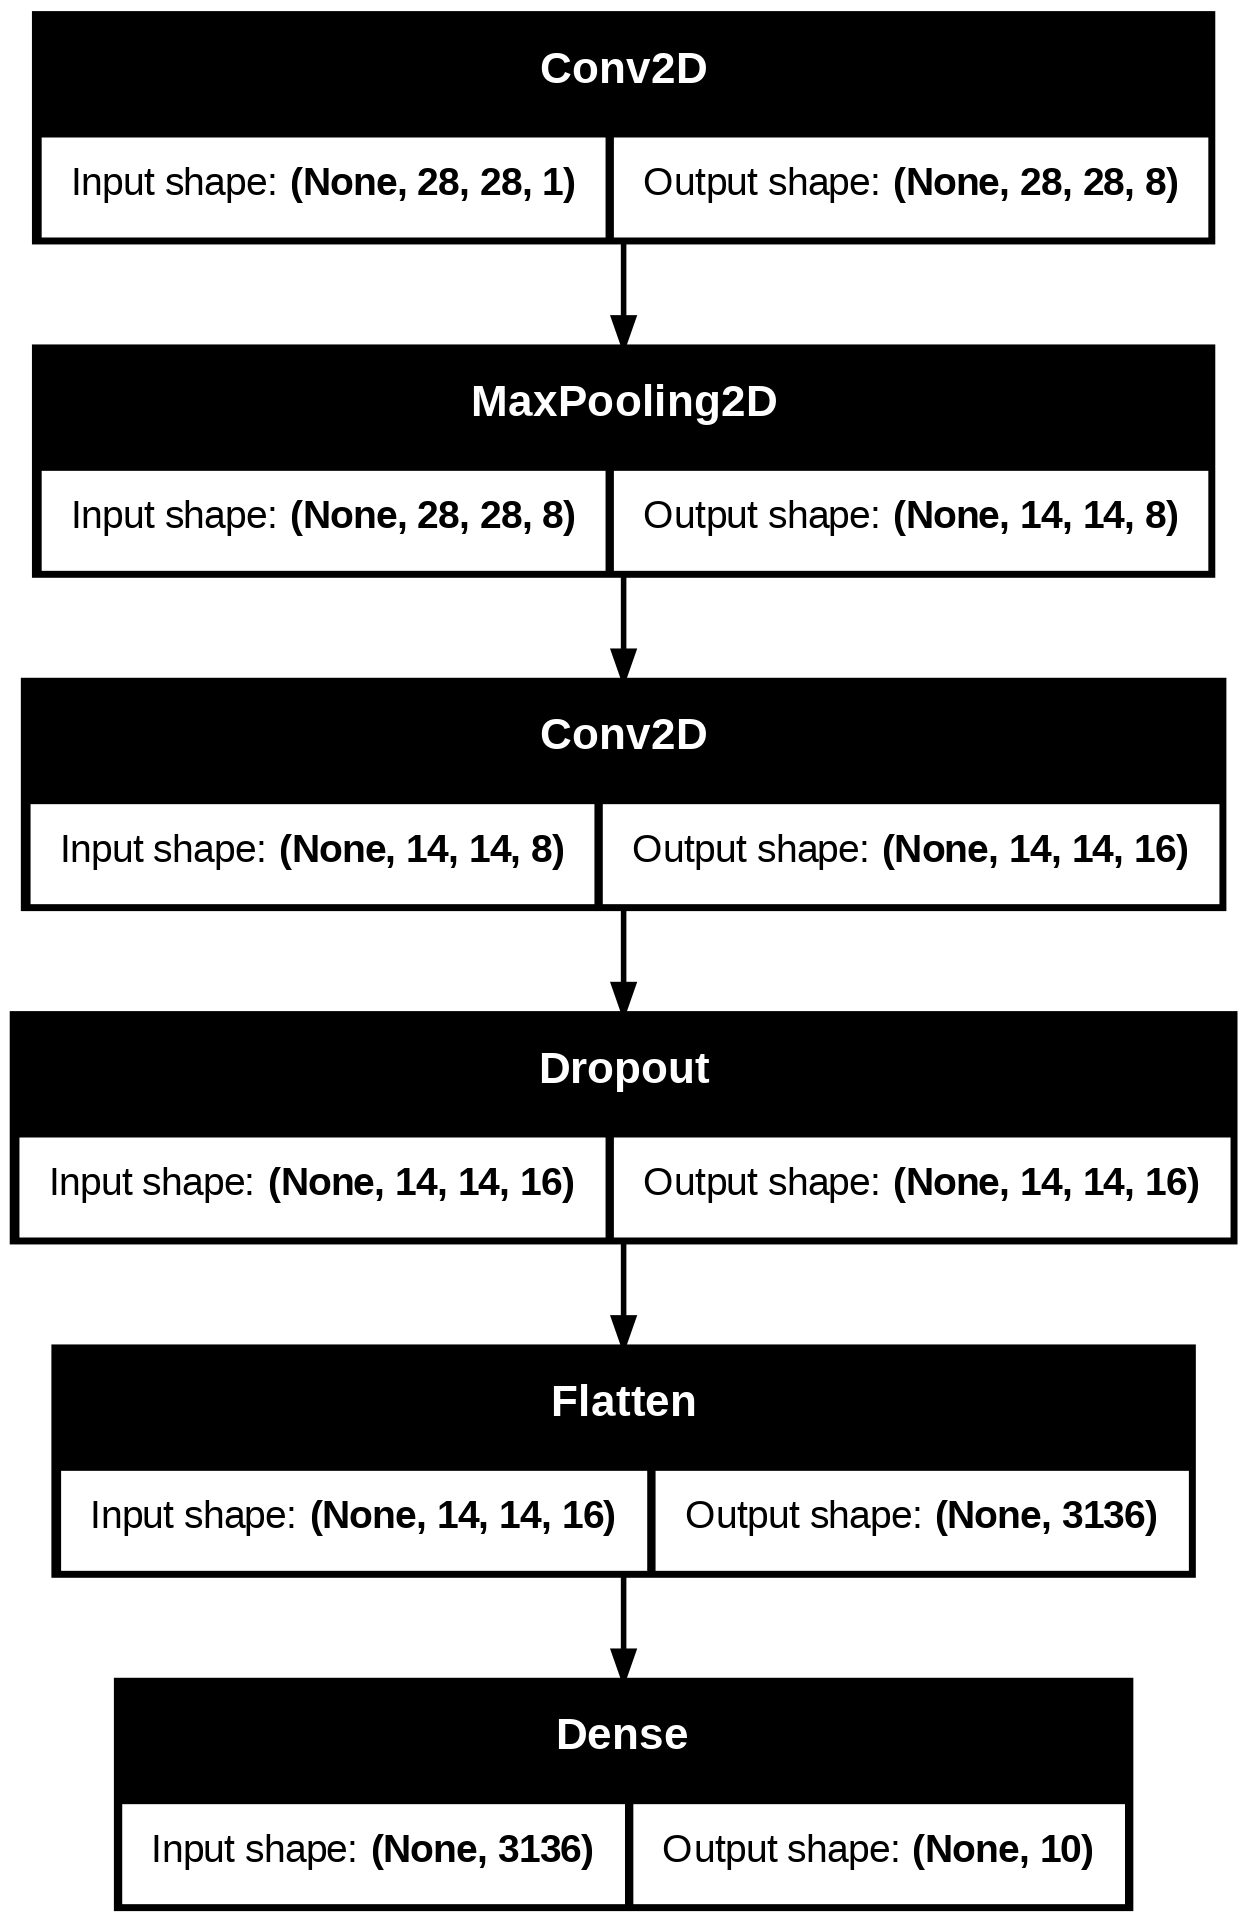

In [78]:
IPython.display.Image( plotFile)

## Count the parameters

In [79]:
mnist_conv2_8_16_pool_model.count_params()

32618

In [80]:
def createModelSeq(input_shape, num_classes):
  model = Sequential( [
                       Input(shape=input_shape),
                       Conv2D(8, kernel_size=(3, 3),
                              activation='relu',
                              padding="same"),
                       MaxPooling2D(pool_size=(2, 2)),
                       Conv2D(32, (3, 3), activation='relu'),
                       #MaxPooling2D(pool_size=(2, 2)),
                       #Conv2D(128, (3, 3), activation='relu'),
                       Dropout(0.25),
                       Flatten(),
                       #Dense(128, activation='relu'),
                       #Dropout(0.5),
                       Dense(num_classes, activation='softmax')
  ]
)

  return model

modelName="mnist_conv_seq"

mnist_seq_model = createModelSeq(input_shape, num_classes)
acc, plotFile = trainModel(mnist_seq_model, modelName, X_train, y_train, X_test, y_test)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - acc: 0.7344 - loss: 2.5679 - val_acc: 0.8787 - val_loss: 0.3430
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - acc: 0.8768 - loss: 0.3524 - val_acc: 0.8908 - val_loss: 0.3261
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - acc: 0.8953 - loss: 0.2985 - val_acc: 0.8932 - val_loss: 0.3262
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - acc: 0.9044 - loss: 0.2747 - val_acc: 0.8932 - val_loss: 0.3099
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - acc: 0.9121 - loss: 0.2522 - val_acc: 0.8952 - val_loss: 0.3424
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - acc: 0.9132 - loss: 0.2487 - val_acc: 0.8987 - val_loss: 0.3271
Test loss 0.34
Test accuracy: 0.89


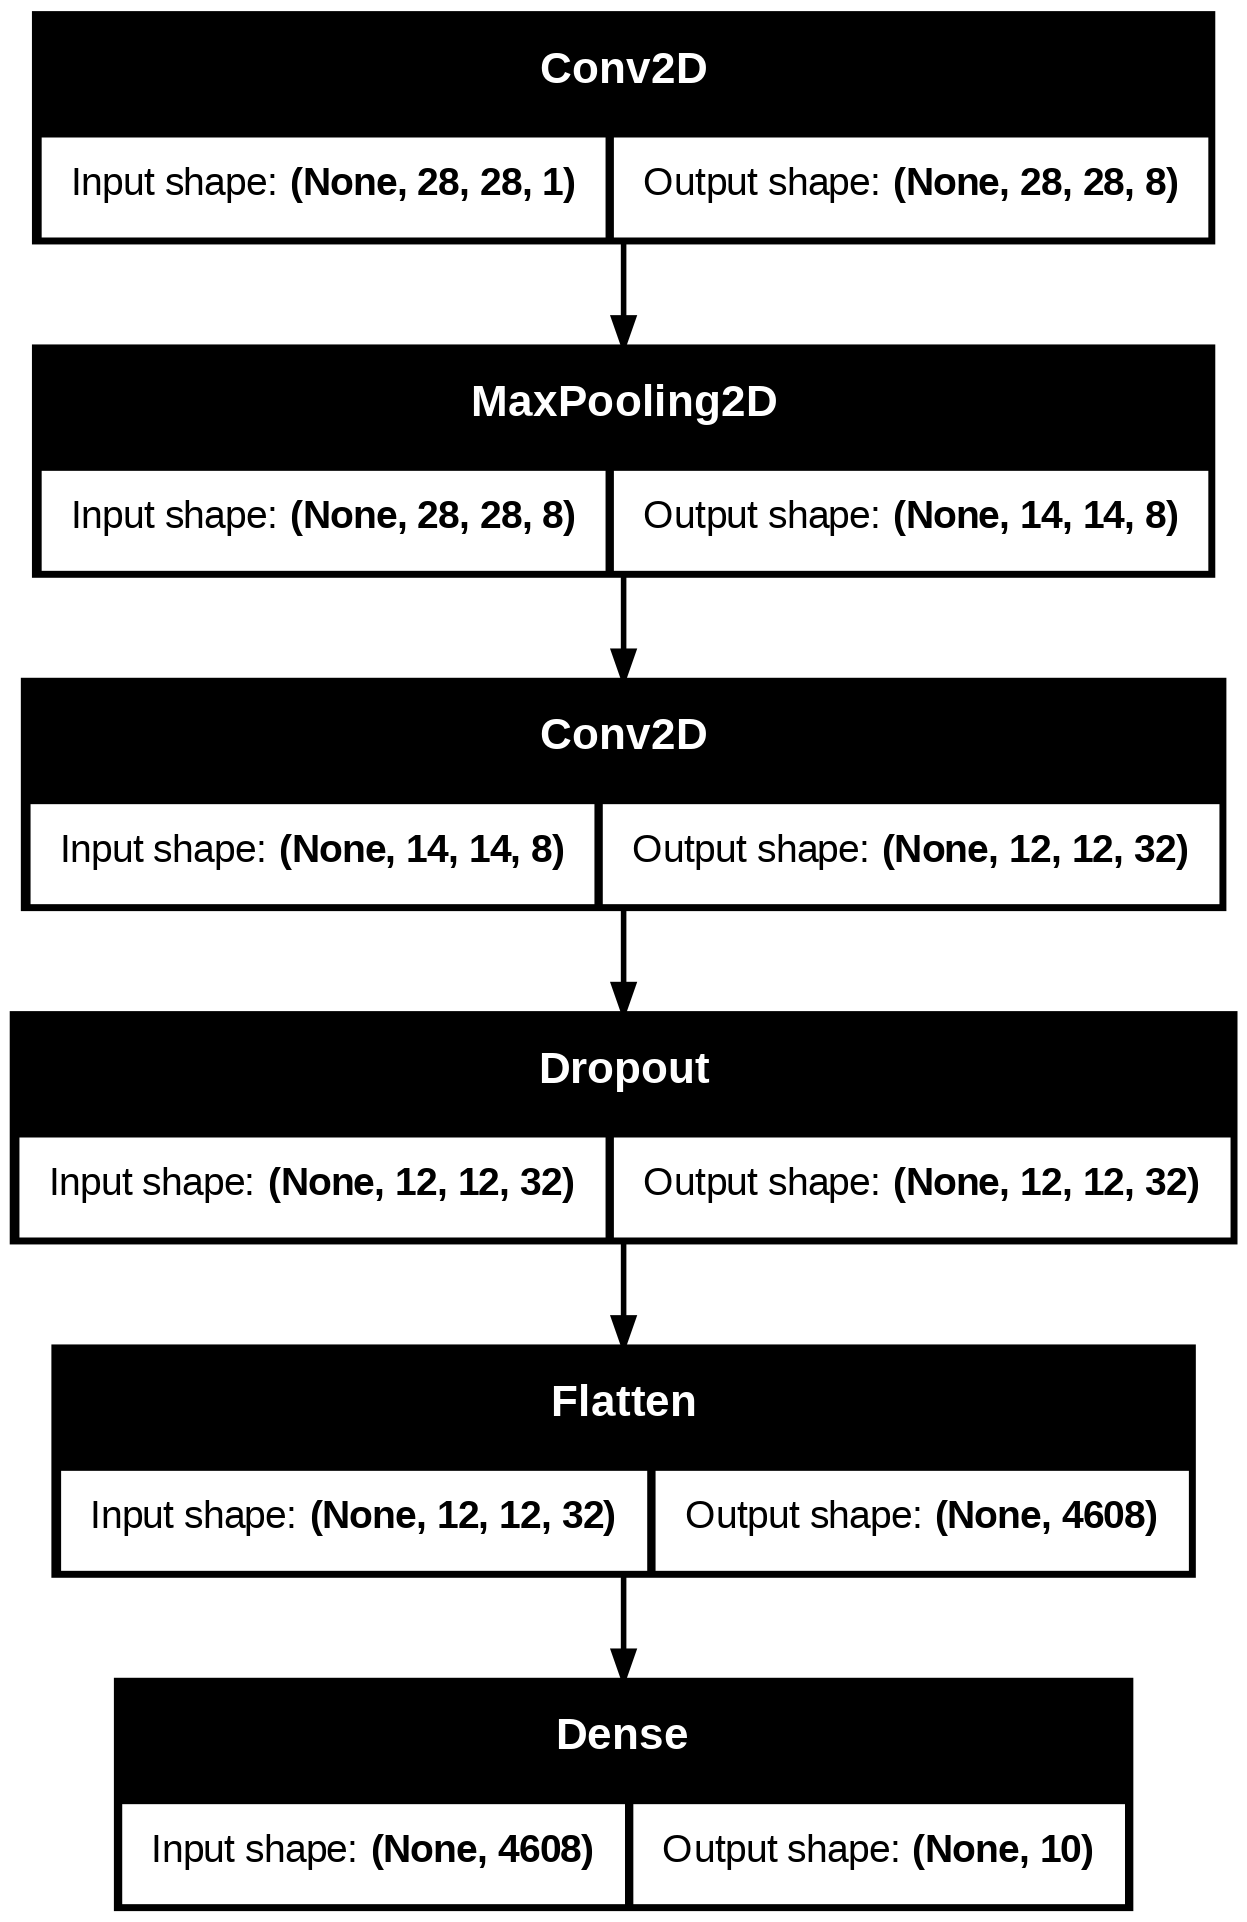

In [81]:
IPython.display.Image( plotFile)

In [82]:
mnist_seq_model.count_params()

48506

# CNN Visualization: Maximally Activating Examples of a Convolutional Feature

Visualize the Maximally Activation example for each Feature Map of the model.

Each Convolutional layer has several features.
- given an input to the model: each convolutional layer outputs a "feature map"
- A feature map
  - has non-feature (i.e., spatial) dimensions
    - typically 2 dimensional
  - each location (i.e., index) of the feature map corresponds to
    - the activation (output) at the location, when the model is presented with a given input

For a particular feature map (i.e., the output of one feature for a particular convolutional layer)
- construct the input to the model
- that "maximally activates" the feature map
  - i.e., results in the greatest average (across locations in the feature map) activation

We can find this maximally activating image
- via Gradient Ascent
  - maximize the average (across locations) of the activations of a feature map
  - by varying the pixels of the model input
  - in the direction that increases the average


Derived from Keras examples https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/visualizing_what_convnets_learn.ipynb

The remainder of the notebook works ONLY with the tensorflow backend of Keras
- uses gradient ascent (hence tf.GradientTape)

In [83]:
# prompt: Exit (with a mesage) the notebook is the keras backend is not tensorflow, as the remainder of the notebook works only in Tensorflow

import sys

if keras.backend.backend() != 'tensorflow':
  print("This notebook requires the TensorFlow backend for Keras.")
  sys.exit()

## Chose a model to visualize

In [84]:
model_vis = mnist_conv2_model
model_vis = mnist_conv2_8_16_pool_model
# model_vis = mnist_seq_model
# model_vis = mnist_conv1_model

layer_dict = dict([(layer.name, layer) for layer in model_vis.layers[0:]])

print(f"Model {model_vis.name} has {len(layer_dict)} layers")
print(f"layer names: {', '.join(list(layer_dict.keys()))}")


Model sequential_28 has 6 layers
layer names: conv2d_25, max_pooling2d, conv2d_26, dropout_2, flatten_28, dense_28


In [85]:
# Set up a model that returns the activation values for our target layer

img_width, img_height, img_channels=X_train[0].shape


## Gradient ascent step

- derive the input to the model (i.e., image)
- that creates the greatest average (across locations) of a feature map
  - feature map activations are obtained by the `feature_extractor` function
  - the specified feature map is given by the `filter_index`

Our goal is to make all the code in the notebook backend-agnostic

This is the only part of the code that is specific to TensorFlow
- uses `tf.GradientTape` to obtain derivative of the "loss" (average activation)
- uses `@tf.function` decorator

In [86]:
@tf.function
def gradient_ascent_step(img, feature_extractor, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, feature_extractor, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)

    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


In [87]:
def compute_loss(input_image, feature_extractor, filter_index):
  """
  Return the average (across spatial dimension) of the values of the features
   in a single feature map

  Parameters
  -----------
  feature_extractor: a feature_extractor created by create_feature_extractor
  filter_index: index of one feature map in the feature maps returned by the feature_extractor

  Returns
  -------
  Average feature value
  """

  activation = feature_extractor(input_image)
  # We avoid border artifacts by only involving non-border pixels in the loss.
  filter_activation = activation[:, 2:-2, 2:-2, filter_index]

  return keras.ops.mean(filter_activation) # Keras 2: keras.ops.reduce_mean(filter_activation)


## Utility routines for visualization

In [88]:
# Create a feature extractor

def create_feature_extractor_obsolete(model, layer_name):
  """
  Create a feature extractor

  Parameters
  ----------
  model: Keras Model object
  layer_name: String.  Name of a layer in model

  Returns
  -------
  function: () => output of layer

    function takes no arguments, returns the outputs (feature maps) of layer layer_name
  """

  layer = model.get_layer(name=layer_name)
  feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=layer.output)

  return feature_extractor

# prompt: visual_layers(model_vis) gives the following error, please fix: Layer conv2d has 32 features
# /usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
# Expected: ['keras_tensor_3']
# Received: inputs=Tensor(shape=(1, 28, 28, 1))
#   warnings.warn(msg)

def create_feature_extractor(model, layer_name):
  """
  Create a feature extractor

  Parameters
  ----------
  model: Keras Model object
  layer_name: String.  Name of a layer in model

  Returns
  -------
  function: () => output of layer

    function takes no arguments, returns the outputs (feature maps) of layer layer_name
  """

  layer = model.get_layer(name=layer_name)
  # Explicitly get the input layer and use its output as the input for the feature extractor
  input_layer = model.layers[0]
  input_layer_output = model.layers[0].output
  feature_extractor = Model(inputs=input_layer.input, outputs=layer.output)

  return feature_extractor


In [89]:
def initialize_image():
    # We start from a gray image with some random noise
    img = keras.random.uniform((1, img_width, img_height, img_channels))

    return img


def visualize_filter(feature_extractor, filter_index, deprocess=True):
    # We run gradient ascent for 20 steps
    iterations = 50
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, feature_extractor, filter_index, learning_rate)

    # Decode the resulting input image
    if deprocess:
      img = deprocess_image(img[0].numpy())
    else:
      img = img[0].numpy()
    return loss, img


def deprocess_image(img):
    print("Deprocess: input shape=", img.shape)
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    print("Deprocess stdize: output shape=", img.shape)
    # Center crop
    img_width, img_height, img_channels=img.shape
    fraction=.1
    img = img[ int(fraction*img_width):int((1-fraction)*img_width), int(fraction*img_height):int((1-fraction)*img_height),:]
    # img = img[25:-25, 25:-25, :]

    print("Deprocess remove edge: output shape=", img.shape)

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")

    print("Deprocess: output shape=", img.shape)
    return img

In [90]:
import regex as re

def visualize_layer(model, layer_name,
                    filter_range=(0,None),
                    deprocess=False
                    ):
  """
  Visualizes the most relevant filters of one conv-layer in a certain model.

  Parameters
  -----------
  model: A model
  layer_name: String.  Name of a Convolutional layer to be visualized
  filter_range: Tuple(index_low, index_hi)
      Only show features with index between index_low and index_hi
  """

  # Create a feature extractor for the layer
  feature_extractor = create_feature_extractor(model_vis, layer_name)

  # How many features in this layer ?
  # Determine from the layer's weights
  # weights[1] is the number of biases, hence the number of features
  num_features = len(model.get_layer(name=layer_name).get_weights()[1])

  print("Layer {l:s} has {n:d} features".format(l=layer_name, n=num_features))

  # Determine the indices of the filters to visualize
  (index_low, index_hi) = filter_range
  if index_hi is None:
    index_hi = num_features

  # Visualize the features
  imgs = {}

  for feature_idx in range(index_low, index_hi):
    loss, img = visualize_filter(feature_extractor, feature_idx, deprocess=False)

    imgs[feature_idx] = img

  num_to_show = (index_hi-1) - index_low +1
  num_per_row = 8
  num_rows = int(num_to_show/num_per_row + 0.5)

  fig, axs=plt.subplots(num_rows, num_per_row, figsize=(12,3*num_rows))
  if len(axs.shape) == 1:
    axs = axs[ np.newaxis, :]

  fig.suptitle("Layer {l:s}".format(l=layer_name), fontsize=14, fontweight="bold")
  feature_idxs = sorted( imgs )

  for i, idx in enumerate(feature_idxs):
    ax = axs[ i // num_per_row, i % num_per_row]
    img = imgs[idx]
    showImage(img, ax=ax, title="Feature {i:d}".format(i=idx) )


def visualize_layers(model, layer_names=None,
                    filter_range=(0,None),
                    deprocess=False
                    ):
  """
  Visualizes the most relevant filters of the conv-layers in a certain model.

  Parameters
  -----------
  model: A model
  layer_names: Array of String.  Names of a Convolutional layer to be visualized
  filter_range: Tuple(index_low, index_hi)
      Only show features with index between index_low and index_hi
  """

  if layer_names is None:
    # Find the Convolutional layers, assuming names contain "conv"
    layer_names = []
    layers = model.layers

    for layer in layers:
      layer_name = layer.name

      if re.search("conv", layer_name) is not None:
        layer_names.append(layer_name)


  for layer_name in layer_names:
    visualize_layer(model, layer_name, filter_range=filter_range)



## Visualize the Maximally Activation example for each Feature Map of the model

Layer conv2d_25 has 8 features
Layer conv2d_26 has 16 features


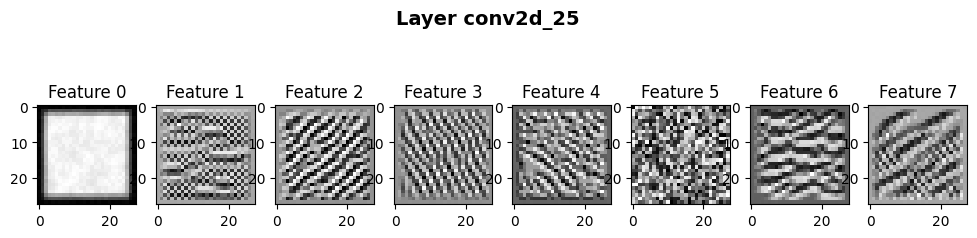

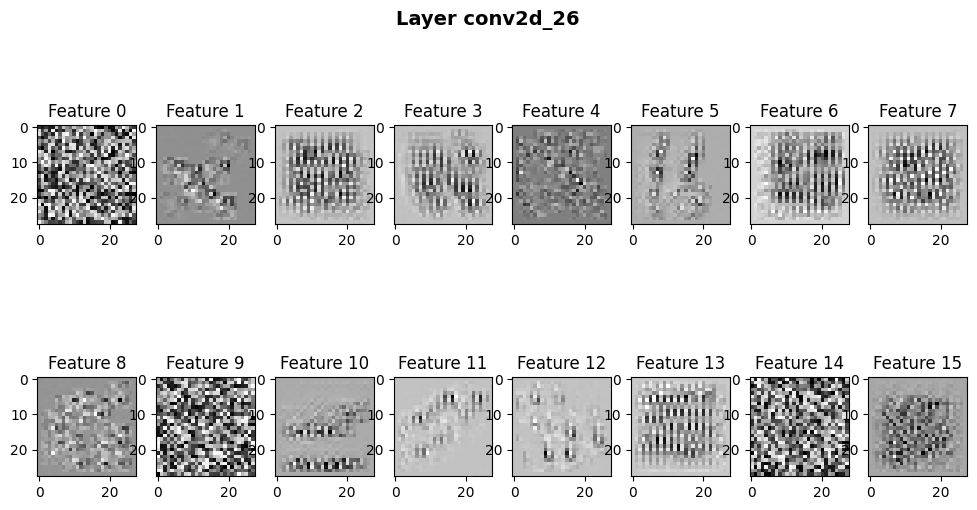

In [91]:
visualize_layers(model_vis)